# Process Parameter Optimization

In [1]:
# ! pip install -r requirements.txt

## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
FILEPATH = os.getenv("FILEPATH")
URL = os.getenv("URL")

In [4]:
print(FILEPATH)

./credentials/empyrean-maxim-406006-63f920d838bd.json


In [5]:
def read_data(path, url):
    scope = ['https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name(path, scope)
    client = gspread.authorize(creds)
    sheet_url = url
    sheet = client.open_by_url(sheet_url)
    worksheet = sheet.get_worksheet(2) 
    data = worksheet.get_all_values()
    return pd.DataFrame(data[1:], columns=data[0])


In [6]:
data = read_data(FILEPATH,URL)

C:\Users\Vardan\AppData\Local\Temp\ipykernel_12984\724327505.py:1: DeprecationWarning: [Deprecated][in version 6.0.0]: client_factory will be replaced by gspread.http_client types
  data = read_data(FILEPATH,URL)


## Data Analysis

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Spindle Speed             108 non-null    object
 1   Feed (mm/min)             108 non-null    object
 2   Tool Dia. (mm)            108 non-null    object
 3   Depth of Cut (mm)         108 non-null    object
 4   Length of Cut (mm)        108 non-null    object
 5   Length of cut actual(mm)  108 non-null    object
 6   Width of Cut(mm)          108 non-null    object
 7   Actual Width(mm)          108 non-null    object
 8   Wi                        108 non-null    object
 9   Wf                        108 non-null    object
 10  delta Weight              108 non-null    object
 11  Time (sec)                108 non-null    object
 12  Time (min)                108 non-null    object
 13  MRR ideal                 108 non-null    object
 14  MRR actual                

In [8]:
data = data.drop(["Density(g/mm3)", "Time (min)", "Time (sec)", "Depth of Cut (mm)", "Length of Cut (mm)","Length of cut actual(mm)", "Width of Cut(mm)", "Actual Width(mm)" ], axis=1)
data = data.astype("float")

In [9]:
data.head()

,Spindle Speed,Feed (mm/min),Tool Dia. (mm),Wi,Wf,delta Weight,MRR ideal,MRR actual,Delta L,Delta W
0,3000.0,10.0,1.0,49.3753,49.3694,0.0059,3.0,1.076451,0.0480,0.18700
1,3000.0,15.0,1.0,49.3694,49.3682,0.0012,4.5,0.327195,0.0640,0.00200
2,3000.0,20.0,1.0,49.3682,49.3659,0.0023,6.0,0.806629,0.0500,0.14500
3,3250.0,10.0,1.0,49.3659,49.3635,0.0024,3.0,1.007537,0.0565,0.14425
4,3250.0,15.0,1.0,49.3635,49.3617,0.0018,4.5,0.553689,0.0605,0.08075


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Spindle Speed   108 non-null    float64
 1   Feed (mm/min)   108 non-null    float64
 2   Tool Dia. (mm)  108 non-null    float64
 3   Wi              108 non-null    float64
 4   Wf              108 non-null    float64
 5   delta Weight    108 non-null    float64
 6   MRR ideal       108 non-null    float64
 7   MRR actual      108 non-null    float64
 8   Delta L         108 non-null    float64
 9   Delta W         108 non-null    float64
dtypes: float64(10)
memory usage: 8.6 KB


array([[<Axes: title={'center': 'Spindle Speed'}>,
        <Axes: title={'center': 'Feed (mm/min)'}>,
        <Axes: title={'center': 'Tool Dia. (mm)'}>],
       [<Axes: title={'center': 'Wi'}>, <Axes: title={'center': 'Wf'}>,
        <Axes: title={'center': 'delta Weight'}>],
       [<Axes: title={'center': 'MRR ideal'}>,
        <Axes: title={'center': 'MRR actual'}>,
        <Axes: title={'center': 'Delta L'}>],
       [<Axes: title={'center': 'Delta W'}>, <Axes: >, <Axes: >]],
      dtype=object)

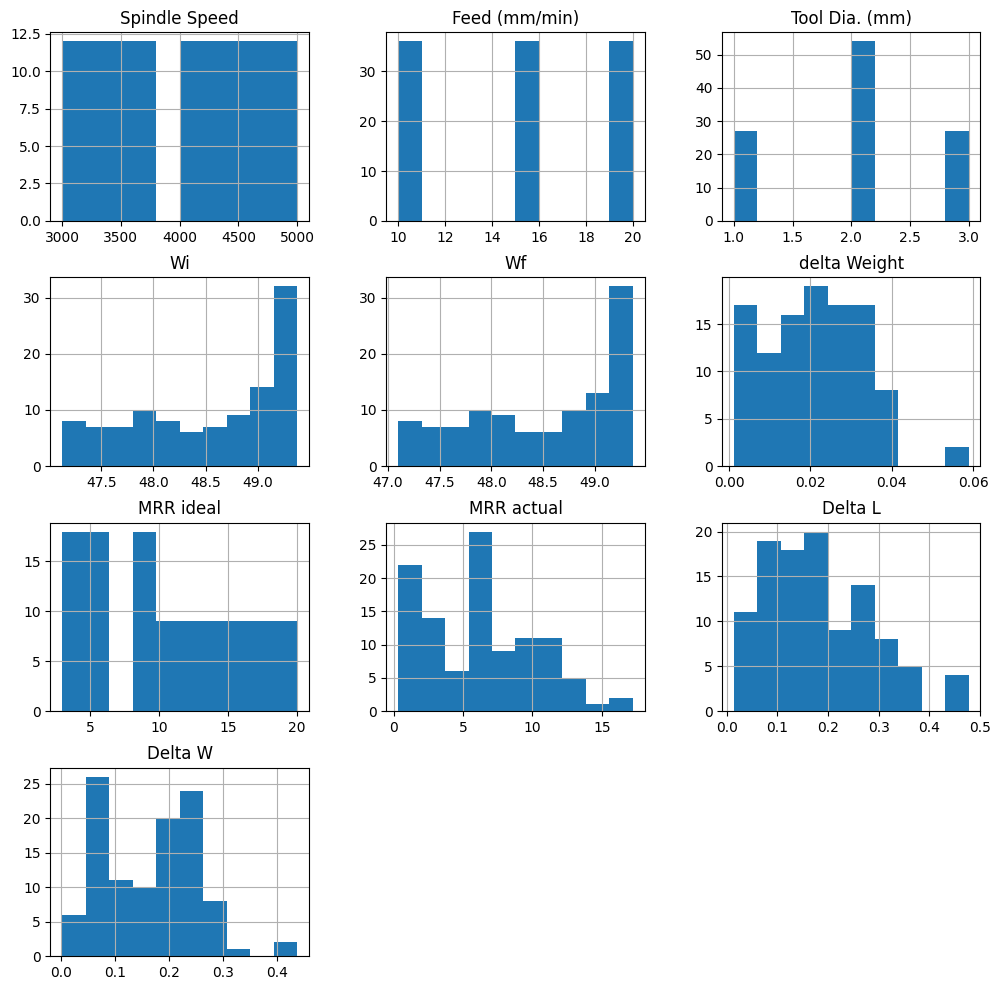

In [11]:
data.hist(figsize=(12,12))

In [12]:
data.corr()["Spindle Speed"].sort_values()

Wi               -2.316687e-01
Wf               -2.288657e-01
delta Weight     -5.537949e-03
Tool Dia. (mm)   -2.481599e-16
MRR ideal        -1.984575e-16
Feed (mm/min)    -1.086517e-16
MRR actual        9.541056e-02
Delta W           1.562890e-01
Delta L           2.144670e-01
Spindle Speed     1.000000e+00
Name: Spindle Speed, dtype: float64

In [13]:
data.corr()["Feed (mm/min)"].sort_values()

Delta L          -9.533012e-02
delta Weight     -5.602127e-02
Wi               -2.463229e-02
Wf               -2.341556e-02
Delta W          -1.963717e-02
Spindle Speed    -1.086517e-16
Tool Dia. (mm)   -3.840069e-17
MRR actual        3.685047e-01
MRR ideal         5.573312e-01
Feed (mm/min)     1.000000e+00
Name: Feed (mm/min), dtype: float64

array([[<Axes: xlabel='Delta W', ylabel='Feed (mm/min)'>,
        <Axes: xlabel='Delta L', ylabel='Feed (mm/min)'>,
        <Axes: xlabel='Feed (mm/min)', ylabel='Feed (mm/min)'>,
        <Axes: xlabel='Spindle Speed', ylabel='Feed (mm/min)'>],
       [<Axes: xlabel='Delta W', ylabel='Spindle Speed'>,
        <Axes: xlabel='Delta L', ylabel='Spindle Speed'>,
        <Axes: xlabel='Feed (mm/min)', ylabel='Spindle Speed'>,
        <Axes: xlabel='Spindle Speed', ylabel='Spindle Speed'>]],
      dtype=object)

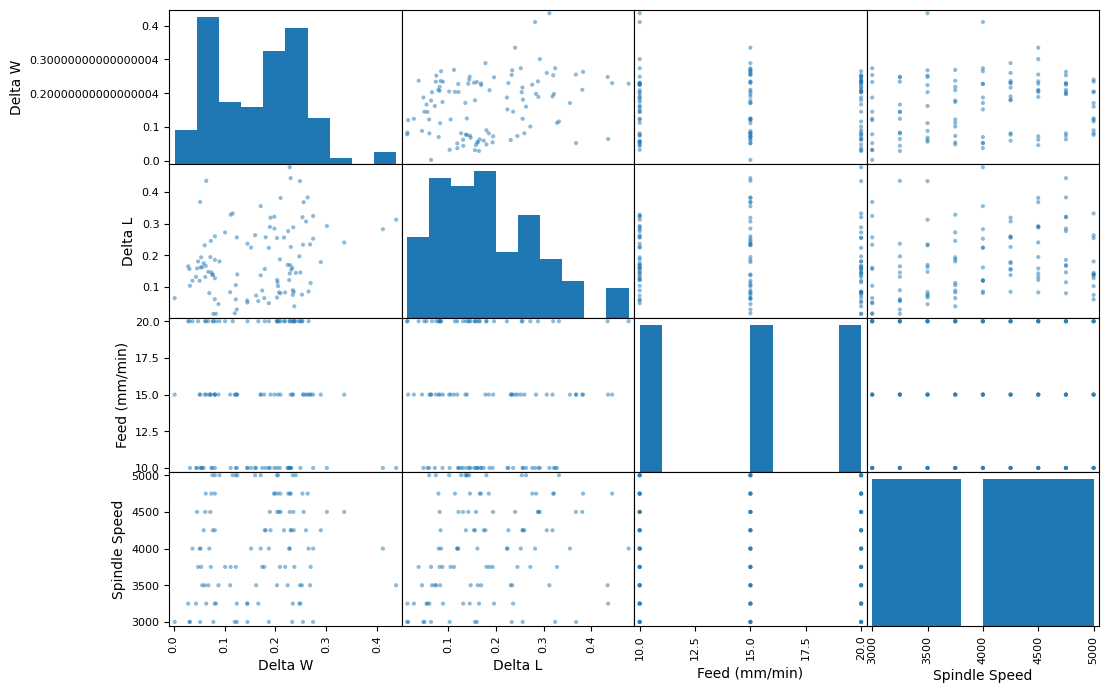

In [14]:
from pandas.plotting import scatter_matrix
attributes=["Delta W", "Delta L", "Feed (mm/min)", "Spindle Speed"]
scatter_matrix(data[attributes], figsize=(12, 8))[2:]

## Data Preprocessing

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
train_set, test_set = train_test_split(data, test_size=0.2, random_state=32)

In [16]:
X_train = train_set.drop(["Spindle Speed", "Feed (mm/min)"], axis = 1)
y_train=pd.concat([train_set["Spindle Speed"], train_set["Feed (mm/min)"]], axis=1)

In [17]:
features_name = X_train.columns
target_name = y_train.columns

## Model Selection

### 1. Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
X_train

,Tool Dia. (mm),Wi,Wf,delta Weight,MRR ideal,MRR actual,Delta L,Delta W
86,2.0,47.7829,47.7544,0.0285,20.0,10.292861,0.1645,0.02850
63,3.0,48.3988,48.3622,0.0366,9.0,7.071112,0.3280,0.11200
39,2.0,49.0267,49.0095,0.0172,6.0,3.296042,0.1210,0.22700
32,2.0,49.1434,49.1284,0.0150,12.0,5.147540,0.0145,0.08300
8,1.0,49.3532,49.3503,0.0029,6.0,1.243090,0.0660,0.20300
...,...,...,...,...,...,...,...,...
62,3.0,48.4374,48.3988,0.0386,18.0,14.257849,0.4340,0.24800
54,3.0,48.7300,48.6940,0.0360,9.0,6.406108,0.2560,0.12400
5,1.0,49.3617,49.3593,0.0024,6.0,0.944173,0.0545,0.16625
43,2.0,48.9651,48.9459,0.0192,9.0,9.295289,0.3065,0.26000


In [20]:
y_train

,Spindle Speed,Feed (mm/min)
86,3250.0,20.0
63,3750.0,10.0
39,4000.0,10.0
32,3250.0,20.0
8,3500.0,20.0
...,...,...
62,3500.0,20.0
54,3000.0,10.0
5,3250.0,20.0
43,4250.0,15.0


### 2. Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor
rnd_reg = RandomForestRegressor(n_estimators=500, max_leaf_nodes=20, n_jobs=-1, max_depth=10)
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("Random Forest", rnd_reg)
])

rf_model = rf_pipeline.fit(X_train, y_train)

In [22]:
rf_model.predict([[2.0,47.7829,47.7544,0.0285,20.0,10.292861,0.1645,0.02850]])

f:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[3272.32738499,   15.85081896]])

In [23]:
estimator = rf_model.named_steps["Random Forest"].estimators_[0]

In [24]:
# ! pip install graphviz

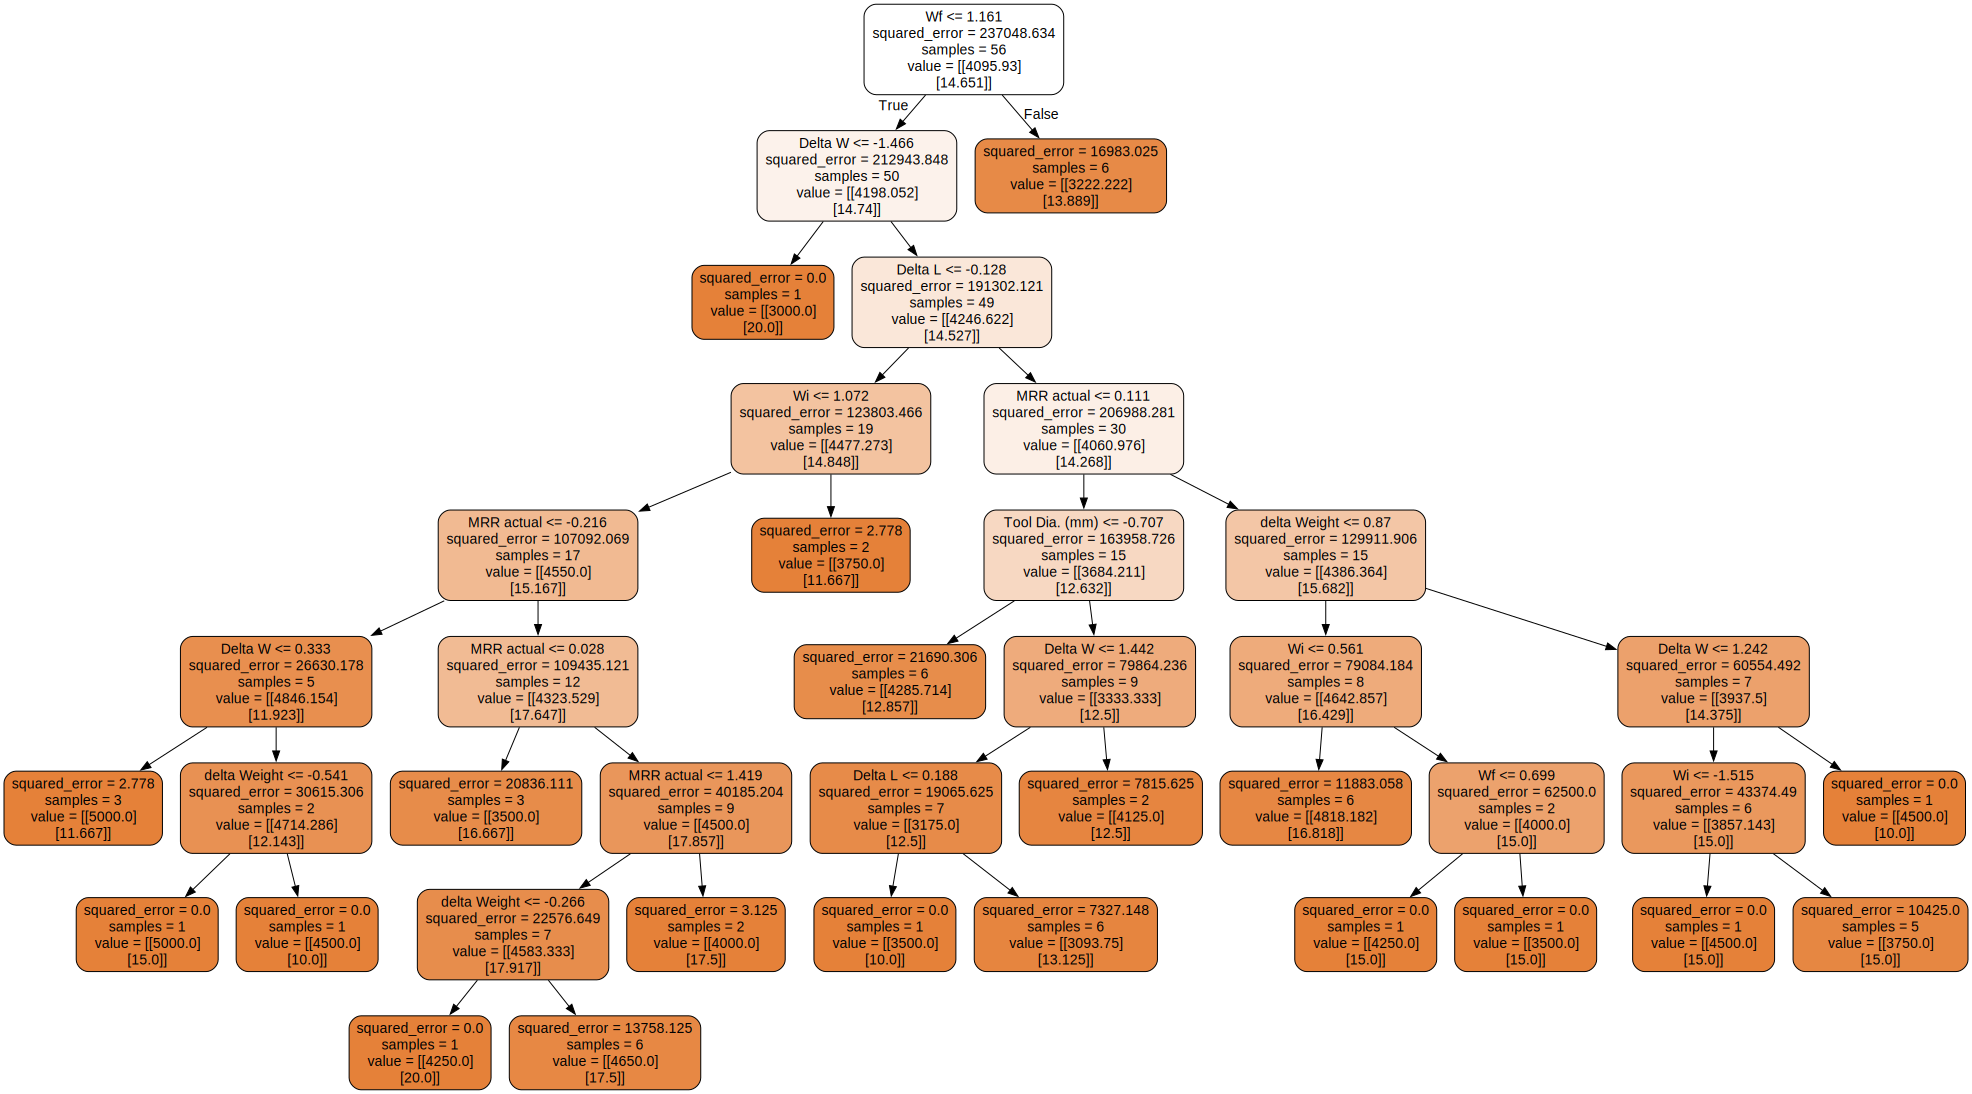

In [25]:
from sklearn.tree import export_graphviz
import graphviz
export_graphviz(estimator, out_file='tree.dot', feature_names=features_name, class_names=target_name, filled=True, rounded=True)
with open('./tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [26]:
from subprocess import call
call(['dot', '-Tpng', './tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

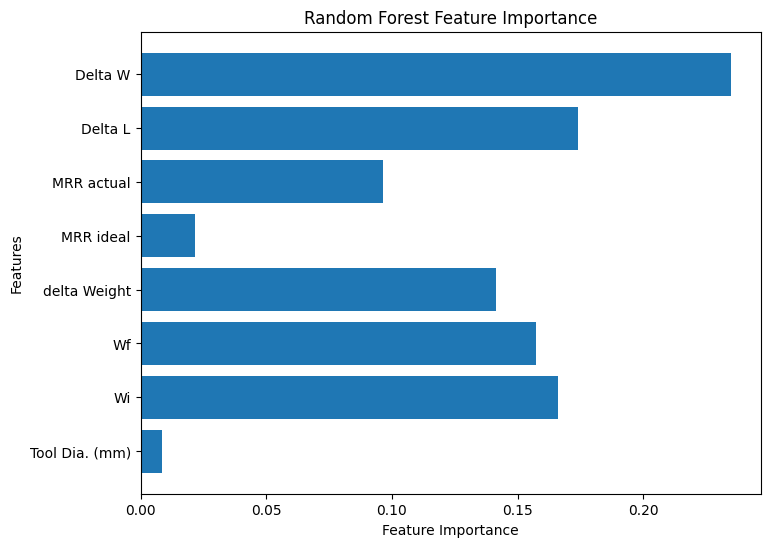

In [27]:
importances = rf_model.named_steps['Random Forest'].feature_importances_
plt.figure(figsize=(8, 6))
plt.barh(features_name, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

## Performance Testing

### 2. Random Forest Performance

In [33]:
from performace_checking import Performance_testing
Performance_testing(rf_model, X_train,y_train, 10)

Scores: [ 80.85009719 125.45876538 465.46292877 172.70287953 254.94188945
 357.41008318 510.16780961 166.71497446 326.04354602 303.58253597
 191.62423056 232.72958721 516.11419641 214.84516476 148.87247776
 304.09561397 552.73532201 523.15232188 366.1210533  100.30211633
 206.98310865 366.02365649 315.95196629 273.02289318 167.3815202
 257.49167765 166.71116966 312.75882692 387.58741383  30.48751636]
Mean: 279.9442447652474
Standard deviation: 136.6981852971556


## Model Optimization

### 1. For Linear Regression

### 2. For Random Forest

In [36]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {
    "bootstrap":[True],
    "n_estimators":[300, 350, 400, 450, 500, 550, 600],
    "max_depth":[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "max_features":["auto","sqrt"],
    "min_samples_leaf":[1, 2, 4],
    "min_samples_split":[2, 5, 10],
}
rnd_new = RandomForestRegressor()
rnd_search = RandomizedSearchCV(rnd_new, param_distributions=random_grid,cv=10,n_jobs=2,random_state=42)


In [37]:
rnd_search.fit(X_train,y_train)

f:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "f:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "f:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\base.py", line 638

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=2,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300, 350, 400, 450,
                                                         500, 550, 600]},
                   random_state=42)

In [38]:
rnd_search.best_estimator_

RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=500)

In [39]:
rnd_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': True}

In [41]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "bootstrap": [True],
    "max_depth": [10, 15, 20, 25,30,40],
    "min_samples_leaf": [1,2,3],
    "min_samples_split": [1,2,3],
    "n_estimators": [500, 525, 600, 650, 700]
}
rnd_new2 = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rnd_new2,param_grid=param_grid,cv=10,n_jobs=2)

In [42]:
grid_search.fit(X_train,y_train)

f:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
900 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "f:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "f:\Projects\Micromilling_process_optimisation\.venv\Lib\site-packages\sklearn\base.py", line 

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=2,
             param_grid={'bootstrap': [True],
                         'max_depth': [10, 15, 20, 25, 30, 40],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [500, 525, 600, 650, 700]})

In [43]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=25, n_estimators=525)

In [44]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 525}

In [47]:
final_rf_model = grid_search.best_estimator_

In [49]:
Performance_testing(final_rf_model,X_train,y_train,10)

Scores: [292.7571868  264.79107158 370.61571324 240.33813473 353.23757403
 489.50303007 252.74673593 269.65360327 285.5704542  253.15785599]
Mean: 307.23713598568315
Standard deviation: 73.22314759521902


In [50]:
import joblib
joblib.dump(final_rf_model,"Random_Forest_Model.pkl")

['Random_Forest_Model.pkl']

## Models Testing

### 2. Random Forest Testing